#Load data

In [ ]:
import zipfile
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
zip_ref = zipfile.ZipFile('/content/gdrive/My Drive/Computer Vision course/car_damage.zip')
zip_ref.extractall()

In [ ]:
Dir = '/content/data1a'

In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk(Dir):
  for filename in filenames:
    print(os.path.join(dirname, filename))

/content/data1a/training/00-damage/0702.JPEG
/content/data1a/training/00-damage/0077.JPEG
/content/data1a/training/00-damage/0097.JPEG
/content/data1a/training/00-damage/0002.JPEG
/content/data1a/training/00-damage/0137.JPEG
/content/data1a/training/00-damage/0243.JPEG
/content/data1a/training/00-damage/0170.JPEG
/content/data1a/training/00-damage/0805.JPEG
/content/data1a/training/00-damage/0875.JPEG
/content/data1a/training/00-damage/0214.JPEG
/content/data1a/training/00-damage/0192.JPEG
/content/data1a/training/00-damage/0906.JPEG
/content/data1a/training/00-damage/0022.JPEG
/content/data1a/training/00-damage/0173.JPEG
/content/data1a/training/00-damage/0115.JPEG
/content/data1a/training/00-damage/0388.JPEG
/content/data1a/training/00-damage/0518.JPEG
/content/data1a/training/00-damage/0600.JPEG
/content/data1a/training/00-damage/0491.JPEG
/content/data1a/training/00-damage/0262.JPEG
/content/data1a/training/00-damage/0622.JPEG
/content/data1a/training/00-damage/0143.jpeg
/content/d

In [ ]:
im = cv2.imread('/content/data1a/training/00-damage/0383.jpeg')
plt.imshow(im)

In [ ]:
im = cv2.imread('/content/data1a/training/01-whole/0817.JPEG')
plt.imshow(im)

#import thư viện 

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.layers import GlobalAveragePooling2D, MaxPooling2D, Dropout, Flatten, Dense, Input, BatchNormalization
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os 

#Separate X, y

In [ ]:
Dir_train= '/content/data1a/training'
Dir_val='/content/data1a/validation'
categories = ['00-damage', '01-whole']

LR = 1e-5
Epochs = 50
Bs = 64

data=[]
labels=[]

for category in categories:
  path = os.path.join(Dir_train, category)
  for img in os.listdir(path):
    img_path = os.path.join(path, img)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    data.append(image)
    labels.append(category)

for category in categories:
  path = os.path.join(Dir_val, category)
  for img in os.listdir(path):
    img_path = os.path.join(path, img)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    data.append(image)
    labels.append(category)

In [ ]:
len(data)

2300

In [ ]:
#perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype='float32')
labels = np.array(labels)

(trainX, testX, trainy, testy) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=32) #stratify: phân chia theo tầng

#augmentatioion

In [ ]:
#construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15, 
    horizontal_flip=True, 
    fill_mode='nearest'
)

#Buid Model

In [ ]:
#Load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
#construct the head of the model that will be placed on top of the base model

x = baseModel.output
x = MaxPooling2D(pool_size=(7, 7))(x)
x = Flatten(name="flatten")(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(2, activation="softmax")(x)

#Place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=output)

for layer in baseModel.layers:
	layer.trainable = False

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

compile model

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy']
              )
my_callback = [ReduceLROnPlateau(min_lr=0.0000001), 
               ModelCheckpoint('/mobileNet_epoch_val/mobileNet_{epoch:}_{val_accuracy:}.hdf5', monitor='val_accuracy',save_best_only=True)]


In [ ]:
history = model.fit(
	aug.flow(trainX, trainy, batch_size=Bs),
	steps_per_epoch=len(trainX) // Bs,
	validation_data=(testX, testy),
	validation_steps=len(testX) // Bs,
	epochs=50,
  )

Epoch 1/50
28/28 [==============================] - 79s 3s/step - loss: 2.2365 - accuracy: 0.5231 - val_loss: 1.2664 - val_accuracy: 0.4935
Epoch 2/50
28/28 [==============================] - 69s 2s/step - loss: 1.8728 - accuracy: 0.5446 - val_loss: 1.1108 - val_accuracy: 0.5283
Epoch 3/50
28/28 [==============================] - 69s 2s/step - loss: 1.8143 - accuracy: 0.5529 - val_loss: 1.0337 - val_accuracy: 0.5609
Epoch 4/50
28/28 [==============================] - 71s 3s/step - loss: 1.5584 - accuracy: 0.5963 - val_loss: 0.9747 - val_accuracy: 0.6000
Epoch 5/50
28/28 [==============================] - 69s 2s/step - loss: 1.3396 - accuracy: 0.6216 - val_loss: 0.9019 - val_accuracy: 0.6457
Epoch 6/50
28/28 [==============================] - 69s 2s/step - loss: 1.3413 - accuracy: 0.6306 - val_loss: 0.8427 - val_accuracy: 0.6652
Epoch 7/50
28/28 [==============================] - 71s 3s/step - loss: 1.2139 - accuracy: 0.6346 - val_loss: 0.7889 - val_accuracy: 0.6848
Epoch 8/50
28/28 [==

KeyboardInterrupt: ignored

In [ ]:
model.save('MobileNet_car_damage.model', save_format = 'h5') 

#Predict

In [ ]:
# make predictions on the testing set
predict= model.predict(testX, batch_size=Bs)
pred = np.argmax(predict, axis = 1)

print(classification_report(testy.argmax(axis=1), pred, target_names = lb.classes_))

              precision    recall  f1-score   support

   00-damage       0.97      0.80      0.87       230
    01-whole       0.83      0.97      0.89       230

    accuracy                           0.88       460
   macro avg       0.90      0.88      0.88       460
weighted avg       0.90      0.88      0.88       460



In [ ]:
model.evaluate(testX, testy)

15/15 [==============================] - 1s 47ms/step - loss: 0.2751 - accuracy: 0.8848


[0.2751195430755615, 0.884782612323761]

Show training loss and accuracy

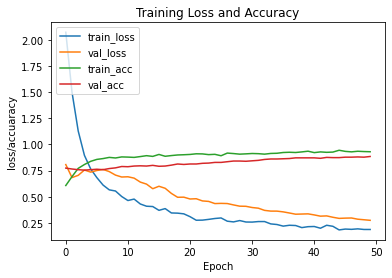

In [ ]:
N = Epochs
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('loss/accuaracy')
plt.legend(loc='upper left')
plt.savefig('mobileNet.png')


predict a random picture

In [ ]:
from keras import models
MobileNet = models.load_model('/content/MobileNet_car_damage.model')


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import matplotlib.pyplot as plt

car is damaged: 0.00015622914, car is not damaged: 0.9998437
the car is not damaged


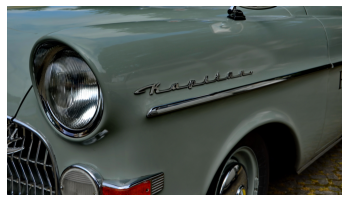

In [ ]:
img_path = '/content/data1a/test_car/car4.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array= image.img_to_array(img)
img_batch = preprocess_input(img_array)
img_batch = np.expand_dims(img_batch, axis = 0)

im = cv2.imread(img_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(im)

pred = MobileNet.predict(img_batch)
print("car is damaged: " + str(pred[0][0])+ ", car is not damaged: " + str(pred[0][1]))
if(pred[0][0] < pred[0][1]): 
  print('the car is not damaged')
else:
  print('the car is damaged')

In [ ]:
path_test = '/content/data1a/test_car'
img_list = []
img_predict=[]

for img in os.listdir(path_test):
  img_path = os.path.join(path_test, img)
  img = image.load_img(img_path, target_size=(224, 224))
  img_array= image.img_to_array(img)
  img_batch = preprocess_input(img_array)
  img_batch = np.expand_dims(img_batch, axis = 0)

  im = cv2.imread(img_path)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  img_list.append(im)
  pred = MobileNet.predict(img_batch)
  #print("car is damaged: " + str(pred[0][0])+ ", car is not damaged: " + str(pred[0][1]))
  if(pred[0][0] < pred[0][1]): 
    img_predict.append('the car is not damaged')
  else:
    img_predict.append('the car is damaged') 




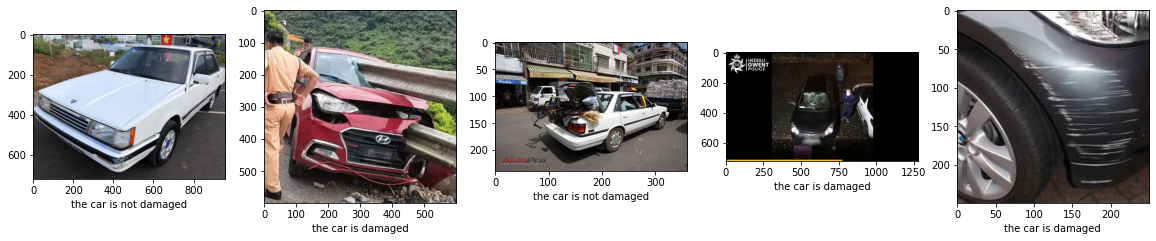

In [ ]:
plt.subplots(figsize=(20, 20))
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(img_list[i])
  plt.xlabel(img_predict[i])
  